In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import csv_to_mplus

In [2]:
save_path = "/users/hjd/IG_my_study/SNUH/data/Mplus/"

In [3]:
abcd_sbj = pd.read_csv("/users/hjd/code/Mplus/ABCD_replication/ABCD_cfa_input.csv",sep = '\t')['subjectkey'].tolist()
len(abcd_sbj)

9987

## Bring CBCL & remove columns
### Michelini [119 -> 102]

In [4]:
cbcl = pd.read_csv("/data5/open_data/ABCD/4.0/Package_1197040/abcd_cbcl01.txt",sep='\t',low_memory=False)
eventname = cbcl.loc[0,'eventname']
sbj_key = cbcl.loc[0,'subjectkey']
cbcl.columns= cbcl.loc[0,:]
cbcl.rename(columns={sbj_key:'subjectkey',eventname:'eventname'},inplace=True)
cbcl.set_index('subjectkey',inplace=True)
cbcl = cbcl.iloc[1:,8:-2]

In [5]:
year0 = cbcl.loc[cbcl['eventname']=="baseline_year_1_arm_1",:]
year1 = cbcl.loc[cbcl['eventname']=="1_year_follow_up_y_arm_1",:]
year2 = cbcl.loc[cbcl['eventname']=="2_year_follow_up_y_arm_1",:]
year3 = cbcl.loc[cbcl['eventname']=="3_year_follow_up_y_arm_1",:]

year0.shape, year1.shape, year2.shape, year3.shape

((11876, 120), (11225, 120), (10414, 120), (6251, 120))

In [6]:
cbcl_year0 = year0.loc[[i for i in abcd_sbj if i in year0.index],:]
cbcl_year1 = year1.loc[[i for i in abcd_sbj if i in year1.index],:]
cbcl_year2 = year2.loc[[i for i in abcd_sbj if i in year2.index],:]
cbcl_year3 = year3.loc[[i for i in abcd_sbj if i in year3.index],:]

cbcl_year0.shape, cbcl_year1.shape, cbcl_year2.shape, cbcl_year3.shape

((9984, 120), (9398, 120), (8721, 120), (5161, 120))

In [7]:
'''Baseline 기준으로!
removed items which frequency was too low (<0.5% rated as 1 or 2)
==> The following CBCL items were removed because of low frequency:
“Drinks alcohol without parents' approval”,
“Sexual problems”, “Smokes, chews, or sniffs tobacco”,
“Truancy, skips school”,
“Uses drugs for non-medical purposes (don't include alcohol or tobacco)”. 
'''
remove_list = []
for i in cbcl_year0:
    cbcl_col = cbcl_year0[i].value_counts(normalize=True,dropna=False).to_dict()
    
    #All have 1 & 2 and sum is below 0.5%
    if '1' in cbcl_col.keys() and '2' in cbcl_col.keys():
        if cbcl_col['1']+cbcl_col['2'] < 0.005:
            print(i)
            remove_list.append(i)
    #Only have 1 and is below 0.5%
    if '1' in cbcl_col.keys() and '2' not in cbcl_col.keys():
        if cbcl_col['1'] < 0.005:
            print(i)
            remove_list.append(i)
    #Only have 2 and is below 0.5%
    if '1' not in cbcl_col.keys() and '2' in cbcl_col.keys():
        if cbcl_col['2'] < 0.005:
            print(i)
            remove_list.append(i)

Drinks alcohol without parents' approval Toma bebidas alcohólicas sin permiso de los padres
Sexual problems Problemas sexuales
Smokes, chews, or sniffs tobacco Fuma, masca o inhala tabaco
Truancy, skips school Falta a la escuela sin motivo
Uses drugs for non medical purposes (don't include alcohol or tobacco) Usa drogas sin motivo médico (no incluya alcohol o tabaco)


In [8]:
cbcl_col = cbcl_year0.columns.tolist()
for i in remove_list:
    cbcl_col.remove(i)
cbcl_col.remove("eventname")
cbcl_year0 = cbcl_year0.loc[:,cbcl_col].astype(float)
cbcl_year1 = cbcl_year1.loc[:,cbcl_col].astype(float)
cbcl_year2 = cbcl_year2.loc[:,cbcl_col].astype(float)
cbcl_year3 = cbcl_year3.loc[:,cbcl_col].astype(float)

cbcl_year0.shape, cbcl_year1.shape, cbcl_year2.shape, cbcl_year3.shape

((9984, 114), (9398, 114), (8721, 114), (5161, 114))

In [9]:
'''
Secondly, to address high inter-item correlations, which can distort factor structure,
we aggregated items that were highly correlated (polychoric r>.75) into composites
by averaging scores and then rounding to the nearest integer,
thus preserving the trichotomous rating. 

The following composites were created:
    Attacks/threatens (“Physically attacks people”, “Threatens people”);
    Destroys (“Destroys his/her own things”,
            “Destroys things belonging to his/her family or others”, “Vandalism”);
    Disobeys rules (“Disobedient at home”, “Disobedient at school”,
                “Breaks rules at home, school or elsewhere”);
    Steals (“Steals at home”, “Steals outside the home”);
    Peer problems (“Doesn't get along with other kids”, “Not liked by other kids”);
    Distracted/Hyperactive (“Can't concentrate, can't pay attention for long”,
                “Inattentive or easily distracted”, “Can't sit still, restless, or hyperactive”);
    Hallucinations (“Hears sound or voices that aren't there”, “Sees things that aren't there”);
    Sex play (“Plays with own sex parts in public”, “Plays with own sex parts too much”);
    Weight problems (“Overeating”, “Overweight”).
    
    EFAs were run on the remaining 93 original and 9 composite items. 
'''
cbcl_col_list = cbcl_year0.columns.tolist()

attack = ["Physically attacks people", "Threatens people"]
destroy = ["Destroys their own things", 
            "Destroys things belonging to their family or others", 
            "Vandalism"]
disobey = ["Disobedient at home",
            "Disobedient at school",
            "Breaks rules at home, school or elsewhere"]
steal = ["Steals at home", "Steals outside the home"]
peer = ["Doesn't get along with other kids", "Not liked by other kids"]
distract = ["Can't concentrate, can't pay attention for long",
            "Inattentive or easily distracted",
            "Can't sit still, restless, or hyperactive"]
hallu = ["Hears sound or voices that aren't there", "Sees things that aren't there"]
sex = ["Plays with own sex parts in public", "Plays with own sex parts too much"]
weight = ["Overeating", "Overweight"]
full = [attack,destroy,disobey,distract,hallu,peer,sex,steal,weight]

attack_cbcl =[]
destroy_cbcl = []
disobey_cbcl = []
steal_cbcl = []
peer_cbcl = []
distract_cbcl = []
hallu_cbcl = []
sex_cbcl = []
weight_cbcl = []
full_cbcl = [attack_cbcl,destroy_cbcl,disobey_cbcl,distract_cbcl,hallu_cbcl,
             peer_cbcl,sex_cbcl,steal_cbcl,weight_cbcl]

idx = 0
for comp in full:
    for item in comp:
        for item2 in cbcl_col_list:
            if item in item2:
                full_cbcl[idx].append(item2)
    idx+=1



In [10]:
#Remove those columns
for i in range(len(full)):
    assert len(full[i]) == len(full_cbcl[i])
for idx in range(len(full)):
    for item in full_cbcl[idx]:
        cbcl_col_list.remove(item)
len(cbcl_col_list)

93

In [11]:
cbcl_year0_efa = cbcl_year0[cbcl_col_list]
cbcl_year1_efa = cbcl_year1[cbcl_col_list]
cbcl_year2_efa = cbcl_year2[cbcl_col_list]
cbcl_year3_efa = cbcl_year3[cbcl_col_list]

cbcl_efa_list = [cbcl_year0_efa,cbcl_year1_efa,cbcl_year2_efa,cbcl_year3_efa]
cbcl_list = [cbcl_year0,cbcl_year1,cbcl_year2,cbcl_year3]

In [12]:
for cbcl_efa_, cbcl_ in zip(cbcl_efa_list,cbcl_list):
    cbcl_efa_['Composite (Attachs/Threatens)'] = np.round(cbcl_[full_cbcl[0]].sum(1)/len(full_cbcl[0]),0)
    cbcl_efa_['Composite (Destroys)'] = np.round(cbcl_[full_cbcl[1]].sum(1)/len(full_cbcl[1]),0)
    cbcl_efa_['Composite (Disobeys rules)'] = np.round(cbcl_[full_cbcl[2]].sum(1)/len(full_cbcl[2]),0)
    cbcl_efa_['Composite (Distracted/Hyperactive)'] = np.round(cbcl_[full_cbcl[3]].sum(1)/len(full_cbcl[3]),0)
    cbcl_efa_['Composite (Hallucinations)'] = np.round(cbcl_[full_cbcl[4]].sum(1)/len(full_cbcl[4]),0)
    cbcl_efa_['Composite (Peer problems)'] = np.round(cbcl_[full_cbcl[5]].sum(1)/len(full_cbcl[5]),0)
    cbcl_efa_['Composite (Sex play)']= np.round(cbcl_[full_cbcl[6]].sum(1)/len(full_cbcl[6]),0)
    cbcl_efa_['Composite (Steals)'] = np.round(cbcl_[full_cbcl[7]].sum(1)/len(full_cbcl[7]),0)
    cbcl_efa_['Composite (Weight problems)'] = np.round(cbcl_[full_cbcl[8]].sum(1)/len(full_cbcl[8]),0)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

In [13]:
cbcl_year0_efa.shape, cbcl_year1_efa.shape, cbcl_year2_efa.shape, cbcl_year3_efa.shape

((9984, 102), (9398, 102), (8721, 102), (5161, 102))

## Rename columns (delete spanish)

In [14]:
loadings = pd.read_excel("/users/hjd/data/ABCD_table/CBCL_loading_factors_from_michelini.xlsx",
                        engine='openpyxl',index_col=0, header=2)
new_col = loadings.index.tolist()[1:-1]
for idx,i in enumerate(new_col):
    new_col[idx]= new_col[idx].replace("his/her","their")
    new_col[idx]= new_col[idx].replace("he/she", "they")
    new_col[idx]= new_col[idx].replace("him/her", "them")

len(new_col)

102

In [15]:
convert_col_dict = {key: value for key, value in dict.fromkeys(cbcl_year0_efa.columns).items()}

In [16]:
remained_col = new_col.copy()
for i in convert_col_dict.keys():
    for j in new_col:
        if j in i:
            convert_col_dict[i] = j
            remained_col.remove(j)
remained_col

['Fails to finish things they starts',
 'There is very little they enjoys',
 'Feels they has to be perfect',
 'Nervous, high-strung, or tense',
 "Stores up too many things they doesn't need"]

## Romer [102 -> 60]

The following 10 items were excluded for cross-loading on more than one factor:

    “Secretive, keeps things to self”
    “Strange behavior,”
    “There is very little he/she enjoys,”
    “Unhappy, sad, or depressed,”
    “Unusually loud,”
    “Deliberatively harms self or attempts suicide,”
    “Feels or complains that no one loves him/her,”
    “Impulsive or acts without thinking,”
    “Talks about killing self,”
    “Overtired without good reason.” 

In [17]:
cross_loading = ["Secretive, keeps things to self",
    "Strange behavior",
    "There is very little they enjoy",
    "Unhappy, sad, or depressed",
    "Unusually loud",
    "Deliberately harms self or attempts suicide",
    "Feels or complains that no one loves them",
    "Impulsive or acts without thinking",
    "Talks about killing self",
    "Overtired without good reason"] 

In [18]:
cfa_col = cbcl_year0_efa.columns.tolist().copy()
print("Before removing : ",len(cfa_col))
for i in cross_loading:
    for j in cfa_col:
        if i in j:
            cfa_col.remove(j)
print("After removing : ",len(cfa_col))

Before removing :  102
After removing :  92


The following 26 items were excluded for not loading on any factor:

    “Plays with own sex parts in public,”
    “Play with own sex parts too much,”
    “Overeating,”
    “Overweight,”
    “Hears sounds or voices that aren’t there,”
    “Sees things that aren’t there,”
    “Bowel movements outside toilet,”
    “Trouble sleeping,”
    “Wets self during the day,”
    “Wets the bed,”
    “Wishes to be of opposite sex,”
    “Clings to adult or too dependent,”
    “Cries a lot,”
    “Doesn’t eat well,”
    “Gets teased a lot,”
    “Bites fingernails,”
    “Nightmares,”
    “Constipated, doesn’t move bowels,”
    “Picks nose, skin, or other parts of body,”
    “Prefers being with older kids,”
    “Sleeps less than most kids,”
    “Sleeps more than most kids,”
    “Speech problem,”
    “Stores up too many things he/she doesn’t need,”
    “Talks or walks in sleep,”
    “Thumb-sucking.” 

In [19]:
not_loading = ["Plays with own sex parts in public",
    "Play with own sex parts too much",
    "Overeating",
    "Overweight",
    "Hears sound or voices that aren't there",
    "Sees things that aren’t there",
    "Bowel movements outside toilet",
    "Trouble sleeping",
    "Wets self during the day",
    "Wets the bed",
    "Wishes to be of opposite sex",
    "Clings to adults or too dependent",
    "Cries a lot",
    "Doesn't eat well",
    "Gets teased a lot",
    "Bites fingernails",
    "Nightmares",
    "Constipated, doesn't move bowels",
    "Picks nose, skin, or other parts of body",
    "Prefers being with older kids",
    "Sleeps less than most kids",
    "Sleeps more than most kids during day and/or night",
    "Speech problem",
    "Stores up too many things they don't need",
    "Talks or walks in sleep",
    "Thumb-sucking" ]

In [20]:
print("Before removing : ",len(cfa_col))
for i in not_loading:
    for j in cfa_col:
        if i in j:
            cfa_col.remove(j)
print("After removing : ",len(cfa_col))

Before removing :  92
After removing :  72


Six composite scores were created (Michelini et al., 2019):

    Composite 1 (“Physically attacks people” + “Threatens people”);
    
    Composite 2 (“Disobedient at home” + “Disobedient at school” + “Breaks rules at home, school, or elsewhere”);
    
    Composite 3 (“Destroys his/her own things” + “Destroys things belonging to his/her family or others” + “Vandalism”);
    
    Composite 4 (“Steals at home” + “Steals outside the home”);
    
    Composite 5 (“Doesn’t get along with other kids” + “Not liked by other kids”);
    
    Composite 6 (“Can’t concentrate, can’t pay attention for long” + “Inattentive or easily distracted” + “Can’t sit still, restless, or hyperactive”).

In [21]:
print("Before removing : ",len(cfa_col))
cfa_col.remove('Composite (Hallucinations)')
cfa_col.remove('Composite (Sex play)')
cfa_col.remove('Composite (Weight problems)')
print("After removing : ",len(cfa_col))

Before removing :  72
After removing :  69


We removed 3 additional CBCL items for cross-loading on more than one factor

    (“Showing off or clowning,” “Strange ideas,” and “Talks too much”),
    
4 items that did not have enough variability

    (“Thinks about sex too much,” “Sets fires,” “Self-conscious or easily embarrassed,” and “Cruel to animals”),
    
and one item that resulted in a non-positive definite solution

    (“Other physical problems without known physical cause”) at one or more of the waves.

This left a total of 60 CBCL items/composites entered into the CFAs at each wave.

In [22]:
remove_further=["Showing off or clowning",
                "Strange ideas",
                "Talks too much",
               "Thinks about sex too much",
                "Sets fires",
                "Self-conscious or easily embarrassed",
                "Cruel to animals",
               'Other (physical problems without known physical cause)',
                #Romer가 언급 빠뜨린 column 추가로 제거
               'Stares blankly']

In [23]:
print("Before removing : ",len(cfa_col))
for i in remove_further:
    for j in cfa_col:
        if i in j:
            cfa_col.remove(j)
print("After removing : ",len(cfa_col))

Before removing :  69
After removing :  60


In [24]:
cbcl_year0_cfa = cbcl_year0_efa[cfa_col]
cbcl_year1_cfa = cbcl_year1_efa[cfa_col]
cbcl_year2_cfa = cbcl_year2_efa[cfa_col]
cbcl_year3_cfa = cbcl_year3_efa[cfa_col]

cbcl_year0_cfa.dropna(how='all',inplace=True)
cbcl_year1_cfa.dropna(how='all',inplace=True)
cbcl_year2_cfa.dropna(how='all',inplace=True)
cbcl_year3_cfa.dropna(how='all',inplace=True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value

In [25]:
cbcl_year0_cfa.shape, cbcl_year1_cfa.shape, cbcl_year2_cfa.shape, cbcl_year3_cfa.shape

((9984, 60), (9398, 60), (8721, 60), (5161, 60))

## Order columns for factor scores dimensions
### (Ext, Int, Nd, Som, Det)

In [26]:
romer_cfa_col_origin = pd.read_csv("/users/hjd/IG_my_study/SNUH/data/Mplus/Romer_cfa_before_column_ordering.csv",sep='\t',index_col=0).columns
romer_cfa_col_ordered = pd.read_csv("/users/hjd/IG_my_study/SNUH/data/Mplus/Romer_cfa.csv",sep='\t',index_col=0).columns

In [27]:
for i in range(len(cbcl_year0_cfa.columns)):
    print(romer_cfa_col_origin[i])
    print(cbcl_year0_cfa.columns[i])
    print("==========================")

Acts too young for his/her age
Acts too young for their age
Argues a lot
Argues a lot Discute mucho
Fails to finish things he/she starts
Fails to finish things they start
Bragging, boasting
Bragging, boasting  Es engreído(a), presumido(a)
Can't get his/her mind off certain thoughts; obsessions
Can't get their mind off certain thoughts; obsessions
Complains of loneliness
Complains of loneliness Se queja de que se siente solo(a)
Confused or seems to be in a fog
Confused or seems to be in a fog Está confundido(a) o parece como si estuviera en las nubes
Cruelty, bullying, or meanness to others
Cruelty, bullying, or meanness to others Es cruel, abusador(a), y malo(a) con los demás
Daydreams or gets lost in his/her thoughts
Daydreams or gets lost in their thoughts
Demands a lot of attention
Demands a lot of attention Exige mucha atención
Doesn't seem to feel guilty after misbehaving
Doesn't seem to feel guilty after misbehaving No parece sentirse culpable después de portarse mal
Easily jealo

In [28]:
cbcl_year0_cfa.columns = romer_cfa_col_origin
cbcl_year1_cfa.columns = romer_cfa_col_origin
cbcl_year2_cfa.columns = romer_cfa_col_origin
cbcl_year3_cfa.columns = romer_cfa_col_origin

cbcl_year0_cfa = cbcl_year0_cfa[romer_cfa_col_ordered]
cbcl_year1_cfa = cbcl_year1_cfa[romer_cfa_col_ordered]
cbcl_year2_cfa = cbcl_year2_cfa[romer_cfa_col_ordered]
cbcl_year3_cfa = cbcl_year3_cfa[romer_cfa_col_ordered]

## SNUH data for cfa

In [29]:
snuh = pd.read_excel("/users/hjd/data/SNUH_CBCL.xlsx", engine="openpyxl",index_col=0)
snuh = snuh.iloc[1:]
snuh.rename(columns={'r_no':'subjectkey'},inplace=True)
snuh.set_index('subjectkey',drop=True,inplace=True)
snuh.dropna(how='all',inplace=True)
snuh.columns = year0.columns

In [30]:
snuh.head()

,Acts too young for their age,Drinks alcohol without parents' approval Toma bebidas alcohólicas sin permiso de los padres,Argues a lot Discute mucho,Fails to finish things they start,There is very little they enjoy,Bowel movements outside toilet Hace sus necesidades en la ropa o en lugares inadecuados,"Bragging, boasting Es engreído(a), presumido(a)","Can't concentrate, can't pay attention for long No puede concentrarse o prestar atención por mucho tiempo",Can't get their mind off certain thoughts; obsessions,"Can't sit still, restless, or hyperactive No puede quedarse quieto(a); es inquieto(a) o hiperactivo(a)",...,Unusually loud Más ruidoso(a) de lo común,Uses drugs for non medical purposes (don't include alcohol or tobacco) Usa drogas sin motivo médico (no incluya alcohol o tabaco),"Vandalism Comete actos de vandalismo, como romper ventanas u otras cosas",Wets self during the day Se orina en la ropa durante el día,Wets the bed Se orina en la cama,Whining Se queja mucho,Wishes to be of opposite sex Desea ser del sexo opuesto,"Withdrawn, doesn't get involved with others Se aísla, no se relaciona con los demás",Worries Se preocupa mucho,eventname
subjectkey,,,,,,,,,,,,,,,,,,,,,
P1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
P2,0.0,1.0,2.0,1.0,0.0,0.0,0.0,1.0,2.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,NaN
P3,1.0,NaN,2.0,0.0,2.0,1.0,1.0,2.0,2.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,NaN
P4,2.0,0.0,2.0,0.0,0.0,0.0,0.0,2.0,2.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
P5,2.0,0.0,2.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,NaN


In [31]:
snuh_col = snuh.columns.tolist().copy()
snuh_col.remove('eventname')
for i in remove_list:
    snuh_col.remove(i)
for idx in range(len(full)):
    for item in full_cbcl[idx]:
        snuh_col.remove(item)

In [32]:
snuh_efa = snuh[snuh_col]
snuh_efa['Composite (Attachs/Threatens)'] = np.round(snuh[full_cbcl[0]].sum(1)/len(full_cbcl[0]),0)
snuh_efa['Composite (Destroys)'] = np.round(snuh[full_cbcl[1]].sum(1)/len(full_cbcl[1]),0)
snuh_efa['Composite (Disobeys rules)'] = np.round(snuh[full_cbcl[2]].sum(1)/len(full_cbcl[2]),0)
snuh_efa['Composite (Distracted/Hyperactive)'] = np.round(snuh[full_cbcl[3]].sum(1)/len(full_cbcl[3]),0)
snuh_efa['Composite (Hallucinations)'] = np.round(snuh[full_cbcl[4]].sum(1)/len(full_cbcl[4]),0)
snuh_efa['Composite (Peer problems)'] = np.round(snuh[full_cbcl[5]].sum(1)/len(full_cbcl[5]),0)
snuh_efa['Composite (Sex play)']= np.round(snuh[full_cbcl[6]].sum(1)/len(full_cbcl[6]),0)
snuh_efa['Composite (Steals)'] = np.round(snuh[full_cbcl[7]].sum(1)/len(full_cbcl[7]),0)
snuh_efa['Composite (Weight problems)'] = np.round(snuh[full_cbcl[8]].sum(1)/len(full_cbcl[8]),0)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

In [33]:
snuh_cfa = snuh_efa[cfa_col]
snuh_cfa.columns = romer_cfa_col_origin
snuh_cfa = snuh_cfa[romer_cfa_col_ordered]

In [34]:
snuh_efa.shape, snuh_cfa.shape

((147, 102), (147, 60))

In [35]:
abcd_snuh_y0 = pd.concat([cbcl_year0_cfa, snuh_cfa])
abcd_snuh_y1 = pd.concat([cbcl_year1_cfa, snuh_cfa])
abcd_snuh_y2 = pd.concat([cbcl_year2_cfa, snuh_cfa])
abcd_snuh_y3 = pd.concat([cbcl_year3_cfa, snuh_cfa])

In [36]:
abcd_snuh_y0.shape, abcd_snuh_y1.shape, abcd_snuh_y2.shape, abcd_snuh_y3.shape

((10131, 60), (9545, 60), (8868, 60), (5308, 60))

In [42]:
cbcl_year0_cfa

,Composite (Attachs/Threatens),"Cruelty, bullying, or meanness to others",Composite (Disobeys rules),Gets in many fights,Temper tantrums or hot temper,Argues a lot,Composite (Destroys),Screams a lot,Doesn't seem to feel guilty after misbehaving,Swearing or obscene language,...,Headaches,Aches or pains (not stomach or headaches),Feels dizzy or lightheaded,Problems with eyes (not if corrected by glasses),Rashes or other skin problems,"Withdrawn, doesn't get involved with others",Would rather be alone than with others,Too shy or timid,Refuses to talk,"Underactive, slow moving, or lacks energy"
subjectkey,,,,,,,,,,,,,,,,,,,,,
NDAR_INV003RTV85,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
NDAR_INV005V6D2C,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
NDAR_INV007W6H7B,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
NDAR_INV00BD7VDC,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
NDAR_INV00J52GPG,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NDAR_INVZZNX6W2P,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
NDAR_INVZZPKBDAC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
NDAR_INVZZZ2ALR6,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [37]:
# csv_to_mplus.convert(savepath=save_path,filename="ABCD_year0_cfa",
#                      data=cbcl_year0_cfa,allow_nan=True)
# csv_to_mplus.convert(savepath=save_path,filename="ABCD_year1_cfa",
#                      data=cbcl_year1_cfa,allow_nan=True)
# csv_to_mplus.convert(savepath=save_path,filename="ABCD_year2_cfa",
#                      data=cbcl_year2_cfa,allow_nan=True)
# csv_to_mplus.convert(savepath=save_path,filename="ABCD_year3_cfa",
#                      data=cbcl_year3_cfa,allow_nan=True)

# csv_to_mplus.convert(savepath=save_path,filename="SNUH_cfa",
#                      data=snuh_cfa,allow_nan=True)

# csv_to_mplus.convert(savepath=save_path,filename="ABCD+SNUH_year0_cfa",
#                      data=abcd_snuh_y0,allow_nan=True)
# csv_to_mplus.convert(savepath=save_path,filename="ABCD+SNUH_year1_cfa",
#                      data=abcd_snuh_y1,allow_nan=True)
# csv_to_mplus.convert(savepath=save_path,filename="ABCD+SNUH_year2_cfa",
#                      data=abcd_snuh_y2,allow_nan=True)
# csv_to_mplus.convert(savepath=save_path,filename="ABCD+SNUH_year3_cfa",
#                      data=abcd_snuh_y3,allow_nan=True)


In [45]:
romer_cfa_col_ordered

Index(['Composite (Attachs/Threatens)',
       'Cruelty, bullying, or meanness to others',
       'Composite (Disobeys rules)', 'Gets in many fights',
       'Temper tantrums or hot temper', 'Argues a lot', 'Composite (Destroys)',
       'Screams a lot', 'Doesn't seem to feel guilty after misbehaving',
       'Swearing or obscene language', 'Teases a lot', 'Composite (Steals)',
       'Stubborn, sullen, or irritable', 'Lying or cheating',
       'Runs away from home', 'Sudden changes in mood or feelings',
       'Easily jealous', 'Composite (Peer problems)', 'Suspicious',
       'Demands a lot of attention',
       'Hangs around with others who get in trouble',
       'Feels others are out to get him/her', 'Sulks a lot',
       'Bragging, boasting', 'Whining', 'Too fearful or anxious', 'Worries',
       'Feels he/she has to be perfect', 'Feels too guilty',
       'Nervous, high-strung, or tense',
       'Fears he/she might think or do something bad',
       'Feels worthless or inferior

## Selected sbj (ABCD: 6905, SNUH: 125)

In [41]:
abcd_sbj = np.load("/users/hjw/data/ABCD/npz_files/sbj_keys.npz",allow_pickle=True)['X']
abcd_sbj_key = ["NDAR_"+i for i in abcd_sbj]

snuh_sbj = np.load("/data4/SNU/data/cur_sbj_list.npz",allow_pickle=True)['X']
snuh_sbj_key = [i[0]+str(int(i[1:])) for i in snuh_sbj]

In [52]:
abcd_snuh_y0_sel = pd.concat([cbcl_year0_cfa.loc[sbj_key],snuh_cfa.loc[snuh_sbj_key]])
abcd_snuh_y0_sel

,Composite (Attachs/Threatens),"Cruelty, bullying, or meanness to others",Composite (Disobeys rules),Gets in many fights,Temper tantrums or hot temper,Argues a lot,Composite (Destroys),Screams a lot,Doesn't seem to feel guilty after misbehaving,Swearing or obscene language,...,Headaches,Aches or pains (not stomach or headaches),Feels dizzy or lightheaded,Problems with eyes (not if corrected by glasses),Rashes or other skin problems,"Withdrawn, doesn't get involved with others",Would rather be alone than with others,Too shy or timid,Refuses to talk,"Underactive, slow moving, or lacks energy"
subjectkey,,,,,,,,,,,,,,,,,,,,,
NDAR_INV003RTV85,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0.0,0,0,0.0,1.0,0.0,0.0,0.0
NDAR_INV00BD7VDC,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0,0,0.0,0,0,0.0,0.0,0.0,0.0,0.0
NDAR_INV00LH735Y,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,1,0,0.0,0,0,0.0,0.0,0.0,0.0,0.0
NDAR_INV00LJVZK2,0.0,0.0,2.0,1.0,2.0,1.0,1.0,0.0,2.0,0.0,...,0,0,0.0,0,0,0.0,0.0,0.0,0.0,0.0
NDAR_INV00R4TXET,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1,0,0.0,0,0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
P88,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0.0,0,0,1.0,2.0,1.0,1.0,0.0
P90,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0,0,0.0,0,0,0.0,0.0,0.0,0.0,0.0
P91,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0,0,0.0,0,0,0.0,0.0,0.0,0.0,1.0


In [53]:
# csv_to_mplus.convert(savepath=save_path,filename="ABCD+SNUH_year0_cfa_selected_sbj",
#                      data=abcd_snuh_y0_sel,allow_nan=True)

In [62]:
#Factor score save
abcd_snuh_y0_fs_sel = csv_to_mplus.get_fs_score(datapath=save_path+"ABCD+SNUH_year0_cfa_selected_sbj.csv",num_factors=6)
abcd_snuh_y0_fs_sel_df = pd.DataFrame(data= np.array(abcd_snuh_y0_fs_sel), index = abcd_snuh_y0_sel.index, columns = ['ext','int','neu','som','det','p'])
abcd_snuh_y0_fs_sel_df.to_csv(save_path+"ABCD+SNUH_year0_cfa_selected_sbj_factor_scores.csv", sep='\t')

## Factor score save

In [76]:
fs_columns = ['ext','int','neu','som','det','p']

abcd_snuh_y0_fs = csv_to_mplus.get_fs_score(datapath=save_path+"ABCD+SNUH_year0_cfa.csv",num_factors=6)
abcd_snuh_y0_fs_df = pd.DataFrame(data= np.array(abcd_snuh_y0_fs), index = abcd_snuh_y0.index, columns = fs_columns)
abcd_snuh_y0_fs_df.to_csv(save_path+"ABCD+SNUH_year0_cfa_factor_scores.csv", sep='\t')

abcd_snuh_y1_fs = csv_to_mplus.get_fs_score(datapath=save_path+"ABCD+SNUH_year1_cfa.csv",num_factors=6)
abcd_snuh_y1_fs_df = pd.DataFrame(data= np.array(abcd_snuh_y1_fs), index = abcd_snuh_y1.index, columns = fs_columns)
abcd_snuh_y1_fs_df.to_csv(save_path+"ABCD+SNUH_year1_cfa_factor_scores.csv", sep='\t')

abcd_snuh_y2_fs = csv_to_mplus.get_fs_score(datapath=save_path+"ABCD+SNUH_year2_cfa.csv",num_factors=6)
abcd_snuh_y2_fs_df = pd.DataFrame(data= np.array(abcd_snuh_y2_fs), index = abcd_snuh_y2.index, columns = fs_columns)
abcd_snuh_y2_fs_df.to_csv(save_path+"ABCD+SNUH_year2_cfa_factor_scores.csv", sep='\t')

abcd_snuh_y3_fs = csv_to_mplus.get_fs_score(datapath=save_path+"ABCD+SNUH_year3_cfa.csv",num_factors=6)
abcd_snuh_y3_fs_df = pd.DataFrame(data= np.array(abcd_snuh_y3_fs), index = abcd_snuh_y3.index, columns = fs_columns)
abcd_snuh_y3_fs_df.to_csv(save_path+"ABCD+SNUH_year3_cfa_factor_scores.csv", sep='\t')

abcd_y0_fs = csv_to_mplus.get_fs_score(datapath=save_path+"ABCD_year0_cfa.csv",num_factors=6)
abcd_y0_fs_df = pd.DataFrame(data= np.array(abcd_y0_fs), index = cbcl_year0_cfa.index, columns = fs_columns)
abcd_y0_fs_df.to_csv(save_path+"ABCD_year0_cfa_factor_scores.csv", sep='\t')

abcd_y1_fs = csv_to_mplus.get_fs_score(datapath=save_path+"ABCD_year1_cfa.csv",num_factors=6)
abcd_y1_fs_df = pd.DataFrame(data= np.array(abcd_y1_fs), index = cbcl_year1_cfa.index, columns = fs_columns)
abcd_y1_fs_df.to_csv(save_path+"ABCD_year1_cfa_factor_scores.csv", sep='\t')

abcd_y2_fs = csv_to_mplus.get_fs_score(datapath=save_path+"ABCD_year2_cfa.csv",num_factors=6)
abcd_y2_fs_df = pd.DataFrame(data= np.array(abcd_y2_fs), index = cbcl_year2_cfa.index, columns = fs_columns)
abcd_y2_fs_df.to_csv(save_path+"ABCD_year2_cfa_factor_scores.csv", sep='\t')

abcd_y3_fs = csv_to_mplus.get_fs_score(datapath=save_path+"ABCD_year3_cfa.csv",num_factors=6)
abcd_y3_fs_df = pd.DataFrame(data= np.array(abcd_y3_fs), index = cbcl_year3_cfa.index, columns = fs_columns)
abcd_y3_fs_df.to_csv(save_path+"ABCD_year3_cfa_factor_scores.csv", sep='\t')

In [94]:
abcd_y0_fs_df_melt = abcd_y0_fs_df.melt()
abcd_y0_fs_df_melt['data'] = 'y0'
abcd_y1_fs_df_melt = abcd_y1_fs_df.melt()
abcd_y1_fs_df_melt['data'] = 'y1'
abcd_y2_fs_df_melt = abcd_y2_fs_df.melt()
abcd_y2_fs_df_melt['data'] = 'y2'
abcd_y3_fs_df_melt = abcd_y3_fs_df.melt()
abcd_y3_fs_df_melt['data'] = 'y3'

abcd_fs_df_full = pd.concat([abcd_y0_fs_df_melt,abcd_y1_fs_df_melt,
                             abcd_y2_fs_df_melt,abcd_y3_fs_df_melt])

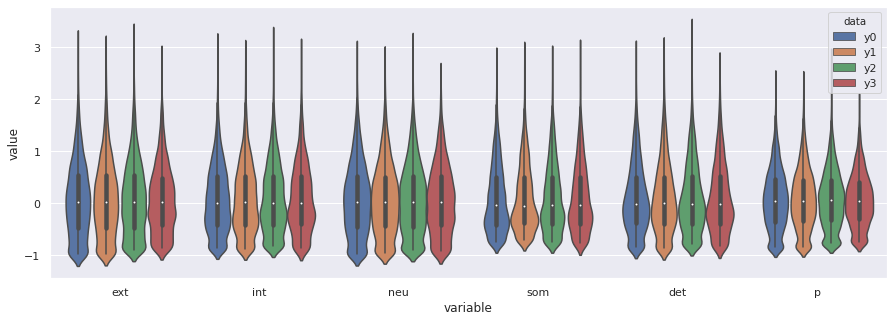

In [97]:
sns.set(style='darkgrid')
plt.figure(figsize=(15,5))
sns.violinplot(x='variable',y='value',hue='data',data=abcd_fs_df_full)
plt.show()

In [107]:
abcd_snuh_y0_fs_df['data'] = 'ABCD_y0'
for i in  abcd_snuh_y0_fs_df.index:
    if 'NDAR' not in i:
        abcd_snuh_y0_fs_df.loc[i,'data'] = 'SNUH_y0'
        
abcd_snuh_y1_fs_df['data'] = 'ABCD_y1'
for i in  abcd_snuh_y1_fs_df.index:
    if 'NDAR' not in i:
        abcd_snuh_y1_fs_df.loc[i,'data'] = 'SNUH_y1'

abcd_snuh_y2_fs_df['data'] = 'ABCD_y2'
for i in  abcd_snuh_y2_fs_df.index:
    if 'NDAR' not in i:
        abcd_snuh_y2_fs_df.loc[i,'data'] = 'SNUH_y2'
        
abcd_snuh_y3_fs_df['data'] = 'ABCD_y3'
for i in  abcd_snuh_y3_fs_df.index:
    if 'NDAR' not in i:
        abcd_snuh_y3_fs_df.loc[i,'data'] = 'SNUH_y3'

In [115]:
abcd_snuh_fs_df_full = pd.concat([abcd_snuh_y0_fs_df.melt(id_vars='data'),abcd_snuh_y1_fs_df.melt(id_vars='data'),
                                     abcd_snuh_y2_fs_df.melt(id_vars='data'),abcd_snuh_y3_fs_df.melt(id_vars='data')])

In [121]:
abcd_snuh_fs_df_full_p = abcd_snuh_fs_df_full.loc[abcd_snuh_fs_df_full['variable']=='p',:]

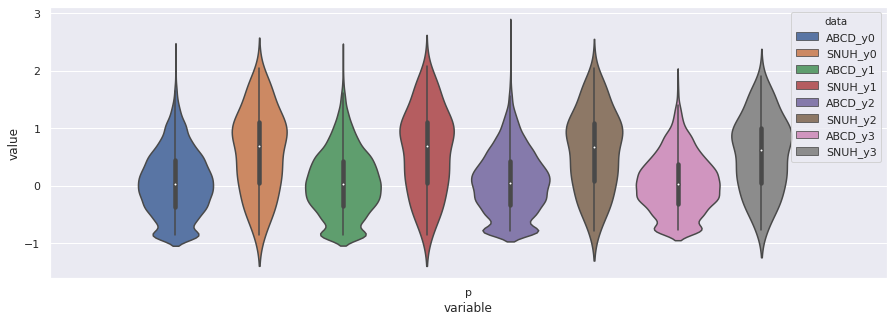

In [122]:
sns.set(style='darkgrid')
plt.figure(figsize=(15,5))
sns.violinplot(x='variable',y='value',hue='data',data=abcd_snuh_fs_df_full_p)
plt.show()

## CBCL 비교

In [138]:
cbcl02 = pd.read_csv("/data5/open_data/ABCD/ABCDstudyDEAP/abcd_cbcl01.txt", sep ='\t', low_memory =False)
eventname = cbcl02.loc[0,'eventname']
sbj_key = cbcl02.loc[0,'subjectkey']
cbcl02.columns= cbcl02.loc[0,:]
cbcl02.rename(columns={sbj_key:'subjectkey',eventname:'eventname'},inplace=True)
cbcl02.set_index('subjectkey',inplace=True)
cbcl02 = cbcl02.iloc[1:,8:-2]

In [141]:
cbcl03 = pd.read_csv("/data5/open_data/ABCD/3.0/abcd_cbcl01.txt",sep='\t',low_memory=False)
eventname = cbcl03.loc[0,'eventname']
sbj_key = cbcl03.loc[0,'subjectkey']
cbcl03.columns= cbcl03.loc[0,:]
cbcl03.rename(columns={sbj_key:'subjectkey',eventname:'eventname'},inplace=True)
cbcl03.set_index('subjectkey',inplace=True)
cbcl03 = cbcl03.iloc[1:,8:-2]

In [139]:
cbcl04 = pd.read_csv("/data5/open_data/ABCD/4.0/Package_1197040/abcd_cbcl01.txt",sep='\t',low_memory=False)
eventname = cbcl04.loc[0,'eventname']
sbj_key = cbcl04.loc[0,'subjectkey']
cbcl04.columns= cbcl04.loc[0,:]
cbcl04.rename(columns={sbj_key:'subjectkey',eventname:'eventname'},inplace=True)
cbcl04.set_index('subjectkey',inplace=True)
cbcl04 = cbcl04.iloc[1:,8:-2]

In [142]:
cbcl02.shape, cbcl03.shape, cbcl04.shape

((16826, 120), (29684, 120), (39766, 120))

In [183]:
cbcl02_y0 = cbcl02.loc[cbcl02['eventname']=='baseline_year_1_arm_1',:]
cbcl03_y0 = cbcl03.loc[cbcl03['eventname']=='baseline_year_1_arm_1',:]
cbcl04_y0 = cbcl04.loc[cbcl04['eventname']=='baseline_year_1_arm_1',:]

cbcl02_y0.shape, cbcl03_y0.shape, cbcl04_y0.shape

((11875, 120), (11878, 120), (11876, 120))

In [184]:
cbcl02_col = cbcl02_y0.columns.tolist()
cbcl02_col.remove('eventname')
cbcl03_col = cbcl03_y0.columns.tolist()
cbcl03_col.remove('eventname')
cbcl04_col = cbcl04_y0.columns.tolist()
cbcl04_col.remove('eventname')

In [238]:
cbcl02_y0 = cbcl02_y0.loc[[i for i in abcd_sbj if i in cbcl02_y0.index],cbcl02_col]
cbcl03_y0 = cbcl03_y0.loc[[i for i in abcd_sbj if i in cbcl03_y0.index],cbcl03_col]
cbcl04_y0 = cbcl04_y0.loc[[i for i in abcd_sbj if i in cbcl04_y0.index],cbcl04_col]

cbcl02_y0.dropna(how='any',inplace=True)
cbcl03_y0.dropna(how='any',inplace=True)
cbcl04_y0.dropna(how='any',inplace=True)

cbcl02_y0.shape, cbcl03_y0.shape, cbcl04_y0.shape

((9979, 119), (9978, 119), (9976, 119))

In [239]:
common_sbj = [i for i in cbcl02_y0.index if i in cbcl03_y0.index and i in cbcl04_y0.index]
len(common_sbj)

9976

In [240]:
cbcl02_y0_fin = cbcl02_y0.loc[common_sbj,:]
cbcl03_y0_fin = cbcl03_y0.loc[common_sbj,:]
cbcl04_y0_fin = cbcl04_y0.loc[common_sbj,:]

cbcl02_y0_fin.shape, cbcl03_y0_fin.shape, cbcl04_y0_fin.shape

((9976, 119), (9976, 119), (9976, 119))

In [241]:
print(np.unique(np.array(cbcl02_y0_fin) == np.array(cbcl03_y0_fin),return_counts=True))
print(np.unique(np.array(cbcl02_y0_fin) == np.array(cbcl04_y0_fin),return_counts=True))
print(np.unique(np.array(cbcl03_y0_fin) == np.array(cbcl04_y0_fin),return_counts=True))

(array([False,  True]), array([     60, 1187084]))
(array([False,  True]), array([     60, 1187084]))
(array([ True]), array([1187144]))


In [242]:
i_sbj, i_col = np.where(np.array(cbcl02_y0_fin) != np.array(cbcl03_y0_fin))
j_sbj, j_col = np.where(np.array(cbcl02_y0_fin) != np.array(cbcl04_y0_fin))
k_sbj, k_col = np.where(np.array(cbcl03_y0_fin) != np.array(cbcl04_y0_fin))

In [246]:
set(i_sbj) == set(j_sbj)

True

In [247]:
set(i_col) == set(j_col)

True

In [248]:
cbcl02_y0_fin.iloc[list(set(i_sbj)),list(set(i_col))]

,Argues a lot Discute mucho,Fails to finish things he/she starts Deja sin terminar lo que él/ella empieza,There is very little he/she enjoys Disfruta de muy pocas cosas,"Can't concentrate, can't pay attention for long No puede concentrarse o prestar atención por mucho tiempo","Can't get his/her mind off certain thoughts; obsessions Obsesiones, que quiere decir que no puede sacarse de la mente ciertos pensamientos","Can't sit still, restless, or hyperactive No puede quedarse quieto(a); es inquieto(a) o hiperactivo(a)",Complains of loneliness Se queja de que se siente solo(a),"Cruelty, bullying, or meanness to others Es cruel, abusador(a), y malo(a) con los demás","Daydreams or gets lost in his/her thoughts Sueña despierto(a), se pierde en sus propios pensamientos",Demands a lot of attention Exige mucha atención,...,Talks about killing self Habla de querer matarse,Talks or walks in sleep Habla o camina cuando está dormido(a),Temper tantrums or hot temper Le dan rabietas o tiene mal genio,Threatens people Amenaza a otros,Trouble sleeping No duerme bien,"Unhappy, sad, or depressed Infeliz, triste, o deprimido(a)",Unusually loud Más ruidoso(a) de lo común,Whining Se queja mucho,"Withdrawn, doesn't get involved with others Se aísla, no se relaciona con los demás",Worries Se preocupa mucho
subjectkey,,,,,,,,,,,,,,,,,,,,,
NDAR_INVAPLUW62L,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
NDAR_INV7XUV8V0N,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,1,0,0,0,1


In [251]:
cbcl04_y0_fin.iloc[list(set(i_sbj)),list(set(i_col))]

,Argues a lot Discute mucho,Fails to finish things they start,There is very little they enjoy,"Can't concentrate, can't pay attention for long No puede concentrarse o prestar atención por mucho tiempo",Can't get their mind off certain thoughts; obsessions,"Can't sit still, restless, or hyperactive No puede quedarse quieto(a); es inquieto(a) o hiperactivo(a)",Complains of loneliness Se queja de que se siente solo(a),"Cruelty, bullying, or meanness to others Es cruel, abusador(a), y malo(a) con los demás",Daydreams or gets lost in their thoughts,Demands a lot of attention Exige mucha atención,...,Talks about killing self Habla de querer matarse,Talks or walks in sleep Habla o camina cuando está dormido(a),Temper tantrums or hot temper Le dan rabietas o tiene mal genio,Threatens people Amenaza a otros,Trouble sleeping No duerme bien,"Unhappy, sad, or depressed Infeliz, triste, o deprimido(a)",Unusually loud Más ruidoso(a) de lo común,Whining Se queja mucho,"Withdrawn, doesn't get involved with others Se aísla, no se relaciona con los demás",Worries Se preocupa mucho
subjectkey,,,,,,,,,,,,,,,,,,,,,
NDAR_INVAPLUW62L,1,1,1,1,1,1,1,1,1,1,...,0,1,1,1,1,1,1,1,2,1
NDAR_INV7XUV8V0N,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [255]:
sbj_fin = cbcl02_y0_fin.index.tolist()
sbj_fin.remove("NDAR_INVAPLUW62L")
sbj_fin.remove("NDAR_INV7XUV8V0N")
len(sbj_fin)

9974

In [67]:
origin = pd.read_csv("/users/hjd/IG_my_study/SNUH/data/Mplus/ABCD+SNUH_year0_cfa_factor_scores.csv",sep='\t',index_col = 0)
selected = abcd_snuh_y0_fs_sel_df

In [70]:
both = pd.concat([origin,selected],axis=1,join='inner')
both

,ext,int,neu,som,det,p,ext,int,neu,som,det,p
subjectkey,,,,,,,,,,,,
NDAR_INV003RTV85,-0.682,-0.537,-0.424,-0.524,0.074,-0.403,-0.716,-0.542,-0.429,-0.531,0.073,-0.413
NDAR_INV00BD7VDC,0.132,0.443,0.457,-0.212,0.061,0.263,0.127,0.436,0.454,-0.207,0.059,0.264
NDAR_INV00LH735Y,0.025,-0.386,-0.413,1.093,-0.290,-0.182,0.034,-0.389,-0.410,1.082,-0.284,-0.182
NDAR_INV00LJVZK2,1.252,0.789,0.985,-0.003,0.413,0.786,1.278,0.768,0.988,0.007,0.402,0.788
NDAR_INV00R4TXET,0.531,0.288,-0.231,0.140,-0.084,0.072,0.545,0.279,-0.240,0.114,-0.093,0.059
...,...,...,...,...,...,...,...,...,...,...,...,...
C53,-0.777,-0.647,-0.482,-0.602,-0.611,-0.554,-0.818,-0.660,-0.501,-0.618,-0.618,-0.578
C54,0.634,0.129,0.166,-0.244,0.006,0.189,0.652,0.126,0.162,-0.242,0.000,0.184
C55,-0.417,-0.339,-0.571,-0.516,-0.085,-0.387,-0.437,-0.344,-0.575,-0.524,-0.085,-0.399


In [77]:
from scipy import stats

In [78]:
stats.pearsonr(both['p'].iloc[:,0],both['p'].iloc[:,1])

(0.9999369016238489, 0.0)

<AxesSubplot:xlabel='p', ylabel='p'>

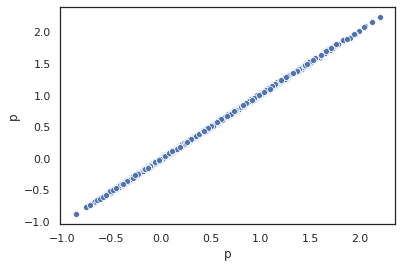

In [80]:
sns.set(style='white')
sns.scatterplot(both['p'].iloc[:,0],both['p'].iloc[:,1])